Задачей даннной работы является выявления преимуществ и недостатков следующих методов оптимизации нулевого и первого порядка:
Замечание:Описание метода предсатвляет сообой переход метода от состояния a к состоинию b ввиду итеративности всех представленных методов 
1) Градиентный спуск с фиксированным шагом. Описание метода: По исходной точке a и значению градиента функции в ней вычисляется точка b как a - grad(f) * learning_rate, где learning_rate - предварительно заданное значение, неизменное на протяжении всей 
2) Градиентный спуск с изменяющимся шагом на основе метода дихотомии. Описание метода:  По исходной точке a и значению градиента функции в ней вычисляется точка b как a - grad(f) * learning_rate1, где learning_rate - результат работы метода дихотомии на функции f(learning_rate1) = a - grad(f) * learning_rate1. Левой границей метода служит 0, правой -learning_rate, задаваемый для градиентного спуска. Вычисление останавливается при достижении заданной точности 
3) Градиентный спуск с изменяющимся шагом на основе метода золотого сечения. Описание метода: аналогичен п.2, за исключением того, что вместо метода дихотомии используется метод золотого сечения
Замечание: для большей стабильности методов 1-3 градиент (в формуле вычисления следующего значения) нормируется
4) Метод покоординатного спуска. Описание метода: Основываясь на исходной точке x и длине шага step_len Итеративно проверяется точка, получаемая из x прибавлением step_len к проверяемой координате. Если значение меньше, чем в x - происходит переход в данную точку, иначе проверяется значение в точке, получаемой из x вычитанием step_len из проверяемой координаты. Если значение в ней меньше, чем в x - происходит переход, иначе аналогичные проверки проводятся по следующей координате. Если перехода не произошло после проверки всех координат, значение step_len уменьшается
5) Метод Нелдера-Мида. Описание метода: Выбираем n + 1 точку, которые образуют n-мерный тетраэдр. Вычисляем значения в этих точках. Дальше сортируем вершины по возрастанию значения функции. Из них выбираем три точки: xh с наибольшим (из выбранных) значением функции fh, xg со следующим по величине значением fg и xl с наименьшим значением функции fl.   ....

In [ ]:
%matplotlib widget
from src.metric import CallCount, GradientCount, PrecisionCount, AbsolutePrecisionCount
from src.common.oracul import LambdaOracul, PoweredSumOracul, GradientLambdaOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import GoldenRatioMethod, GradientDescent, BaseGradientDescent, DichotomyMethod, \
    CoordinateDescent

import matplotlib.pyplot as plt

fig = plt.figure()

golden_ratio = GoldenRatioMethod()
gradient_descent_fix = BaseGradientDescent()
gradient_descent_golden = GradientDescent()
gradient_descent_dichotomy = GradientDescent(method=DichotomyMethod())
coordinate_descent = CoordinateDescent()
oracul = LambdaOracul(lambda x: (x - 10) ** 2)
test_oracul = PoweredSumOracul([[2, 2], [0, 2]])
gradient_oracul = GradientLambdaOracul(lambda x, y: (x - 10) ** 2 + (y - 5) ** 2,
                                       lambda x, y: np.array([2 * (x - 10), 2 * (y - 5)], dtype=np.float64))
point, metrics, anim = MethodProcessor.process(CoordinateDescent(300, 0.01), gradient_oracul, CountCondition(20),
                                               metrics=[CallCount()],
                                               method_params={"start_point": np.array([100, 200]), 'learning_rate': 100},
                                               visualize=True,
                                               low_bracket=[-100, -100], high_bracket=[200, 200])
plt.show()

In [ ]:
base_test = GradientLambdaOracul(lambda x, y: x ** 2 + y ** 2,
                                 lambda x, y: np.array([2 * x, 2 * y], dtype=np.float64))
base_differential = GradientLambdaOracul(lambda x, y: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y,
                                         lambda x, y: np.array([0.52 * x - 0.48 * y, 0.52 * y - 0.48 * x],
                                                               dtype=np.float64))
bad_defined_base = GradientLambdaOracul(lambda x, y: 100 * x ** 2 + y ** 2,
                                        lambda x, y: np.array([200 * x, 2 * y], dtype=np.float64))

In [ ]:
from src.lab1.stop_condition import OrCondition


def tester(methods, oraculs, eps=0.001, start_point=np.array([100, 200]), visualize=True, braket_l=None, braket_h=None,
           learning_rate=300):
    res_points = []
    res_metrics = []
    part_anim_res = []
    for m in methods:
        part_point_res = []
        part_metric_res = []
        for f in oraculs:
            temp_point, temp_metrics, temp_anim = MethodProcessor.process(m, f, PrecisionCondition(eps),
                                                                          metrics=[CallCount(), GradientCount(),
                                                                                   PrecisionCount(eps)],
                                                                          method_params={"x": start_point,
                                                                                         "learning_rate": learning_rate,
                                                                                         "eps": eps},
                                                                          visualize=visualize,
                                                                          low_bracket=braket_l,
                                                                          high_bracket=braket_h)
            part_anim_res += [temp_anim]
            part_point_res += [temp_point]
            part_metric_res += [temp_metrics]
        res_points += [part_point_res]
        res_metrics += [part_metric_res]
    return res_points, res_metrics, part_anim_res


def test_fix_grad(oraculs, params, eps=0.001, start_point=np.array([100, 200]), visualize=False, braket_l=None,
                  braket_h=None):
    res_points = []
    res_metrics = []
    anim_res = []
    for f in range(len(oraculs)):
        temp_point, temp_metrics, temp_anim = MethodProcessor.process(BaseGradientDescent(), oraculs[f],
                                                                      OrCondition(PrecisionCondition(eps),
                                                                                  CountCondition(10 ** 5)),
                                                                      metrics=[CallCount(), GradientCount(),
                                                                               PrecisionCount(eps),
                                                                               AbsolutePrecisionCount(
                                                                                   Point(np.array([0, 0],
                                                                                                  dtype=np.float64)),
                                                                                   eps)],
                                                                      method_params={"x": start_point,
                                                                                     "learning_rate": params[f],
                                                                                     "eps": eps},
                                                                      visualize=visualize,
                                                                      low_bracket=braket_l,
                                                                      high_bracket=braket_h)
        print(temp_point)
        res_points += [temp_point]
        res_metrics += [temp_metrics]
        anim_res += [temp_anim]
    return res_points, res_metrics, anim_res


In [ ]:
tester([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent],
       [base_test, base_differential, bad_defined_base], visualize=False)  #turn on visualization  to demonstration

In [ ]:
#test_fix_grad([base_test, base_differential, bad_defined_base], [0.02, 0.02001, 0.0201], visualize=False)

Замечание: Здесь и далее под методами градиентного спуска понимаются методы на основе градиентного спуска с нефиксированным шагом
Первый тест позволяет обнаружить следубщие особенности методов:
1) Как наиболее явное отличие, методы покоординатного спуска и Нелдера-Мида не требуют вычисления градиента, что является весьма значительной особенностью и выгодно выделяет их на фоне методов градиетного спуска
2) Метод градиетного спуска с фиксированным шагом, хотя и требует вычисления значений функции при данной постановке задачи, не столь сильно в ней нуждается, используя лишь для проверки приближения (как можно заметить, число шагов метода равно числу вычислений значений). Однако едва ли данное преимущество способно перекрыть такие недостатки метода, как отсутствие гарнтии сходимости и потребность в тонкой настройке параметров для обеспечения приемлимой точности или минимальной работоспособности, кроме того число вычислений градиента отличается на порядки ввиду необходимости выставления достаточно малого шага для получения приемлимой точности, кроме того возможны попадания в циклы
3) Хотя методы градиентного спуска и требуют несколько большего числа вычислений значений функции (в основном из-за необходимости вычисления шага с достаточной точностью), число их итераций для достижения искомой точности меньше, чем требуемое для покоординатного спуска *предположительно и Нелдера-Мида*
4) Метод градиентного спуска на основе дихотомии требует значительно большего числа вычисления значений функций, что является ожидаемым следствием меньшей вычислительной эффективности внутреннего метода

Точность 0.01

In [ ]:
tester([GradientDescent(method=GoldenRatioMethod(), aprox_dec=0.001),
        GradientDescent(method=DichotomyMethod(), aprox_dec=0.001), coordinate_descent],
       [base_test, base_differential, bad_defined_base], eps=0.01, visualize=False)

In [ ]:
#test_fix_grad([base_test, base_differential, bad_defined_base], [0.05, 0.05001, 0.0501], eps=0.01, visualize=False)

Точность 0.1

In [ ]:
tester([GradientDescent(method=GoldenRatioMethod(), aprox_dec=0.01),
        GradientDescent(method=DichotomyMethod(), aprox_dec=0.01), coordinate_descent],
       [base_test, base_differential, bad_defined_base], eps=0.1, visualize=False)

In [ ]:
#test_fix_grad([base_test, base_differential, bad_defined_base], [0.101, 0.1001, 0.101], eps=0.1, visualize=False)

Таким образом, при понижении точности, общие тенденции сохраняются, хотя и уменьшается разница в абсолютных значениях.
Тем не менее, стоит обратить внимание на следующие особенности:
 1) понижение точности для градиентных методов означает не только уменьшение числа вычислений функции, но и её градиента
2) Благодаря особенностям работы методов, методы градиентного спуска, как правило, вычисляют значение с некоторым запасом точности, в отличие от метода покоординатного спуска
3) Хотя запрашиваемое приближение для внутренних методов градиентых спусков (дихотомии и золотого сечения) одинаково, можно заметить, что в двух тестах число итераций градиентного спуска на основе метода золотого сечения было меньшим. Вероятно, данная особенность связана с попаданием минимума в меньший из промежутков и, как следствие, вычисление с большей реальной точностью, при меньшем объёме вычислений.
4) Использование метода градиентного спуска с фиксированным шагом на функции неизвестного вида с целью получения заданного приближения видится сомнительным
5) При уменьшении запрашиваемой точности применение метода градиентного спуска с фиксированным шагом видится более целесообразным, нежели при желании получить высокую точность, ведь хотя метод и входил в бесконечный цикл, будучи неспособным приблизиться к точке или понять ,что он уже достаточно близок, приближение происходило за разумное время

Изменённая точка старта

In [ ]:
tester([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent],
       [base_test, base_differential, bad_defined_base], start_point=np.array([10, 20]), visualize=False)

In [ ]:
tester([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent],
       [base_test, base_differential, bad_defined_base], start_point=np.array([-100, -200]), visualize=False)

Влияение выбора точки на работу метдов замечено не было.  

In [ ]:
bad_defined = GradientLambdaOracul(lambda x, y: 1000 * (np.float64(x) - 10) ** 10 + 100 * (np.float64(y) + 20) ** 10,
                                   lambda x, y: np.array(
                                       [1000 * (np.float64(x) - 10) ** 9, 1000 * (np.float64(y) + 20) ** 9],
                                       dtype=np.float64))
tester([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent],
       [bad_defined], start_point=np.array([-100, -200]), eps=0.001, visualize=True, braket_h=[100, 100],
       braket_l=[-100, -100], learning_rate=10)

In [ ]:
#test_fix_grad([bad_defined], [1], eps=0.01, visualize=True)

Таким образом, все методы справляются с выполнением своих задач на плохо обусловленных функциях(по крайней мере, до тех пор, пока их значчения представляется возможным рассчитать), хотя и наиболее эффективен здесь метод покоординатного спуска. Т.к. значение функции меняется весьма значительно даже при небольшом отклонении, методам шрадиентного спуска приходится запрашивать значительное число значений. Так же примечательно то, что метод координатного спуска сделал меньшее число итераций

In [ ]:
isom_function = GradientLambdaOracul(
    lambda x, y: -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi) ** 2 + (y - np.pi) ** 2)),
    lambda x, y: np.array(
        [np.exp(-(x - np.pi) ** 2 - (y - np.pi) ** 2) * np.cos(x) * np.cos(y) + 2 * (x - np.pi) * np.cos(x),
         np.exp(-(x - np.pi) ** 2 - (y - np.pi) ** 2) * np.cos(x) * np.cos(y) + 2 * (y - np.pi) * np.cos(y)],
        dtype=np.float64))
base_mulltimodal = GradientLambdaOracul(lambda x, y: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2,
                                        lambda x, y: np.array([2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7),
                                                               2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)],
                                                              dtype=np.float64))


In [ ]:
tester([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent],
       [base_mulltimodal], start_point=np.array([-1000, -2000]), eps=0.0001, visualize=True, braket_h=[1000, 1000],
       braket_l=[-1000, -1000], learning_rate=10)

Ожидаемым образом, функции сходятся к оптимумам. В случае с base_multimodal - к глобальным (т.к. все являются таковыми), хотя и примечательно, что покоординатный спуск сошёлся к отличному от градиентных

In [ ]:
from src.common.oracul import NoiseOracul

base_mulltimodal_with_noise = NoiseOracul(GradientLambdaOracul(
    lambda x, y: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y,
    lambda x, y: np.array([0.52 * x - 0.48 * y, 0.52 * y - 0.48 * x])), start_noise=0.01, end_noise=0.05)
tester([gradient_descent_golden, gradient_descent_dichotomy], [base_mulltimodal_with_noise],
       start_point=np.array([-1000, -2000]), eps=0.01, visualize=True, braket_h=[1000, 1000],
       braket_l=[-1000, -1000], learning_rate=300)

Замечание: Конечно, шум сильно влияет на время вычесление функции (а еще на мою оперативную память). Но при этом точность не плохая, учитывая присутсвие шума.

In [ ]:
import numpy as np
from src.common.oracul import MultiLambdaOracul, MultiGradientLambdaOracul


def f(params: np.ndarray, i: int) -> float:
    return 100 * (params[i] - params[i - 1] ** 2) ** 2 + (1 - params[i - 1]) ** 2


def grad(params: np.ndarray):
    res = []
    for j in range(len(params)):
        if j == 0:
            res.append(-400 * params[0] * (params[1] - params[0] ** 2) - 2 * (1 - params[0]))
        elif j == len(params) - 1:
            res.append(200 * (params[j] - params[j - 1] ** 2))
        else:
            res.append(
                200 * (params[j] - params[j - 1] ** 2) - 400 * params[j] * (params[j + 1] - params[j] ** 2) - 2 * (
                        1 - params[j]))
    return np.array(res, dtype=np.float64)


coordinate_descent = CoordinateDescent()
gradient_descent_dichotomy = GradientDescent(method=DichotomyMethod())
gradient_descent_golden = GradientDescent()
oracul1 = MultiGradientLambdaOracul(f, grad, 10, start_sum=1)
oracul2 = MultiGradientLambdaOracul(f, grad, 100, start_sum=1)
oracul3 = MultiGradientLambdaOracul(f, grad, 20, start_sum=1)
tester([coordinate_descent, gradient_descent_dichotomy], [oracul1], start_point=np.array([100 for _ in range(10)]),
       eps=0.01, visualize=False, learning_rate=300)

In [ ]:
coordinate_descent = CoordinateDescent()
gradient_descent_dichotomy = GradientDescent(method=DichotomyMethod())
gradient_descent_golden = GradientDescent()
tester([coordinate_descent, gradient_descent_dichotomy, gradient_descent_golden], [oracul3],
       start_point=np.array([100 for i in range(20)]), eps=0.01, visualize=False,
       learning_rate=300)

In [ ]:
coordinate_descent = CoordinateDescent()
gradient_descent_dichotomy = GradientDescent(method=DichotomyMethod())
gradient_descent_golden = GradientDescent()
tester([coordinate_descent, gradient_descent_dichotomy, gradient_descent_golden], [oracul2],
       start_point=np.array([100 for i in range(100)]), eps=0.01, visualize=False,
       learning_rate=300)

Замечание: Как видно из тестов количество вызовов функции выше у метода координатного спуска и на него очень сильно влияет какое n в n-мерной функции. В свою очередь методы основанные на градиентном спуске несильно зависят от n. При этом точнее всего метод координатного спуска, который ближе всего к минимуму (1, 1, ..., 1). (Видимо надо ещё что-то написать, почему так) 

In [ ]:
from src.tests.tester import ScipyTester

oracul1 = LambdaOracul(lambda x: x[0] ** 2 + x[1] ** 2)
oracul2 = LambdaOracul(lambda x, y: x ** 2 + y ** 2)
ScipyTester(["Nelder-Mead"], [(oracul1, oracul2)], start_point=Point(np.array([100, 200]))).test()

In [ ]:
from src.tests.tester import ScipyTester

oracul1 = LambdaOracul(lambda x: 0.26 * (x[0] ** 2 + x[1] ** 2) - 0.48 * x[0] * x[1])
oracul2 = LambdaOracul(lambda x, y: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y)
ScipyTester(["Nelder-Mead"], [(oracul1, oracul2)], start_point=Point(np.array([100, 200]))).test()

In [ ]:
from src.tests.tester import ScipyTester

oracul1 = LambdaOracul(lambda x: 100 * x[0] ** 2 + x[1] ** 2)
oracul2 = LambdaOracul(lambda x, y: 100 * x ** 2 + y ** 2)
ScipyTester(["Nelder-Mead"], [(oracul1, oracul2)], start_point=Point(np.array([100, 200]))).test()

In [ ]:
from src.tests.tester import ScipyTester
import numpy as np


def f(params: np.ndarray, j=0) -> float:
    res = 0
    for i in range(1, len(params)):
        res += 100 * (params[i] - params[i - 1] ** 2) ** 2 + (1 - params[i - 1]) ** 2
    return res


def grad(params: np.ndarray):
    res = []
    for j in range(len(params)):
        if j == 0:
            res.append(-400 * params[0] * (params[1] - params[0] ** 2) - 2 * (1 - params[0]))
        elif j == len(params) - 1:
            res.append(200 * (params[j] - params[j - 1] ** 2))
        else:
            res.append(
                200 * (params[j] - params[j - 1] ** 2) - 400 * params[j] * (params[j + 1] - params[j] ** 2) - 2 * (
                        1 - params[j]))
    return np.array(res, dtype=np.float64)


ScipyTester(["Nelder-Mead"], [(MultiLambdaOracul(f, 10, start_sum=1), MultiLambdaOracul(f, 10, start_sum=1))],
            start_point=Point(np.array([100 for _ in range(10)]))).test()

In [ ]:
ScipyTester(["Nelder-Mead"], [(MultiLambdaOracul(f, 20, start_sum=1), MultiLambdaOracul(f, 20, start_sum=1))],
            start_point=Point(np.array([100 for _ in range(20)])), visualize=False).test()

In [ ]:
from src.tests.tester import ScipyTester

oracul1 = NoiseOracul(LambdaOracul(
    func=lambda x, y: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y, start_noise=0.01, end_noise=0.05))
oracul2 = NoiseOracul(LambdaOracul(
    func=lambda x: 0.26 * (x[0] ** 2 + x[1] ** 2) - 0.48 * x[0] * x[1], start_noise=0.01, end_noise=0.05))

ScipyTester(["Nelder-Mead"], [(oracul2, oracul1)], visualize=False).test()

Выводы: Метод Нелдера — Мида как видно намного меньше раз вызывает функцию, но при этом число итераций заметно больше, чем у методов градиентого спуска. 
Также стоит уопминуть, что в среднем метод делает малое количество вычислений функции, что делает его эффективным, если функция сложная. В многомерном случае метод Нелдера — Мида показывает себя не лучшем образом. Уже при n = 100 ему надо очень много времени, чтобы все рассчитать (я не стал это считать, очень долго). При этом справится с шумом у методв не составляет проблем. 

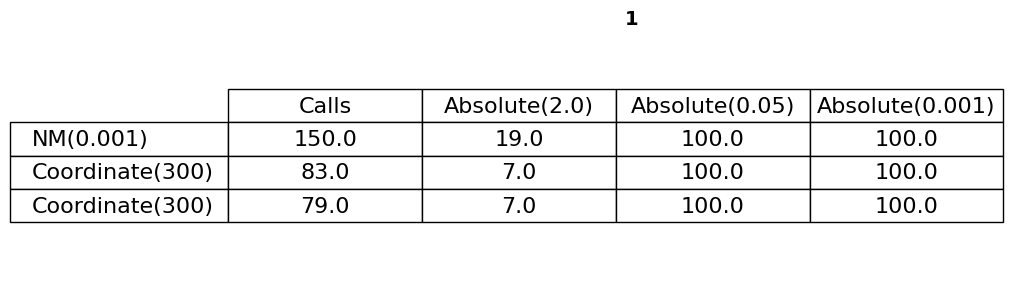

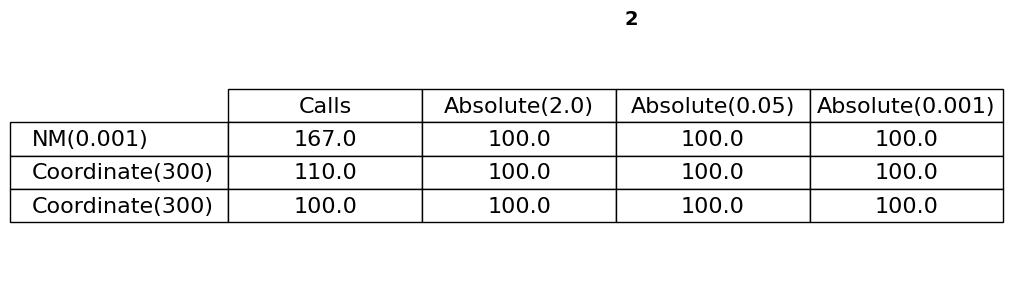

In [1]:
from src.tests.tester import Tester
from src.lab1.methods import NMMethod
from src.lab1.method_processor import MethodProcessor
from src.metric import CallCount, GradientCount, PrecisionCount, AbsolutePrecisionCount
from src.common.oracul import LambdaOracul, PoweredSumOracul, GradientLambdaOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import GoldenRatioMethod, GradientDescent, BaseGradientDescent, DichotomyMethod, \
    CoordinateDescent
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

oracul1 = LambdaOracul(lambda x, y: (x - 123) ** 2 + (y + 60) ** 2)
oracul2 = LambdaOracul(lambda x, y: (x - 23) ** 2 + (y + 200) ** 2)

method1 = NMMethod(0.001)
method2 = CoordinateDescent()
method3 = CoordinateDescent()
metric1 = CallCount()
metric2 = AbsolutePrecisionCount(Point([123, -60, 0]), 2.0)
metric3 = AbsolutePrecisionCount(Point([123, -60, 0]), 0.05)
metric4 = AbsolutePrecisionCount(Point([123, -60, 0]), 0.001)
Tester.test([method1, method2, method3], [oracul1, oracul2], [metric1, metric2, metric3, metric4], CountCondition(100), start_point=[50, 50], noise=0.1)
